<a href="https://colab.research.google.com/github/abhiiyer/ERA1/blob/main/Session-10/ERA_Session10_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.13E-02


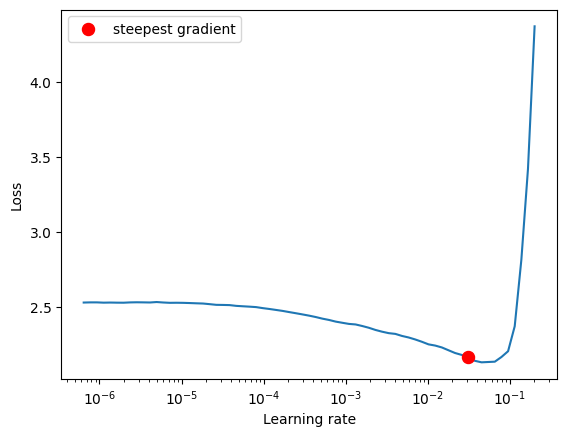

Min LR: 0.045349, Max LR: 0.509414
Epoch [1/24], LR: [0.0008509796720290955], Train Loss: 1.4029, Train Acc: 0.4937, Test Loss: 1.6827, Test Acc: 0.4558
Epoch [2/24], LR: [0.002119175911206604], Train Loss: 0.9580, Train Acc: 0.6613, Test Loss: 0.8698, Test Acc: 0.7053
Epoch [3/24], LR: [0.003966284249193859], Train Loss: 0.7758, Train Acc: 0.7275, Test Loss: 0.9775, Test Acc: 0.6912
Epoch [4/24], LR: [0.006045217889129314], Train Loss: 0.7006, Train Acc: 0.7547, Test Loss: 0.9640, Test Acc: 0.6972
Epoch [5/24], LR: [0.007965328159717826], Train Loss: 0.6097, Train Acc: 0.7882, Test Loss: 0.7505, Test Acc: 0.7728
Epoch [6/24], LR: [0.009365810602588684], Train Loss: 0.5505, Train Acc: 0.8098, Test Loss: 0.7106, Test Acc: 0.7766
Epoch [7/24], LR: [0.009983503087421717], Train Loss: 0.4787, Train Acc: 0.8351, Test Loss: 0.5802, Test Acc: 0.8084
Epoch [8/24], LR: [0.009942723378531746], Train Loss: 0.4304, Train Acc: 0.8522, Test Loss: 0.5000, Test Acc: 0.8413
Epoch [9/24], LR: [0.0097162

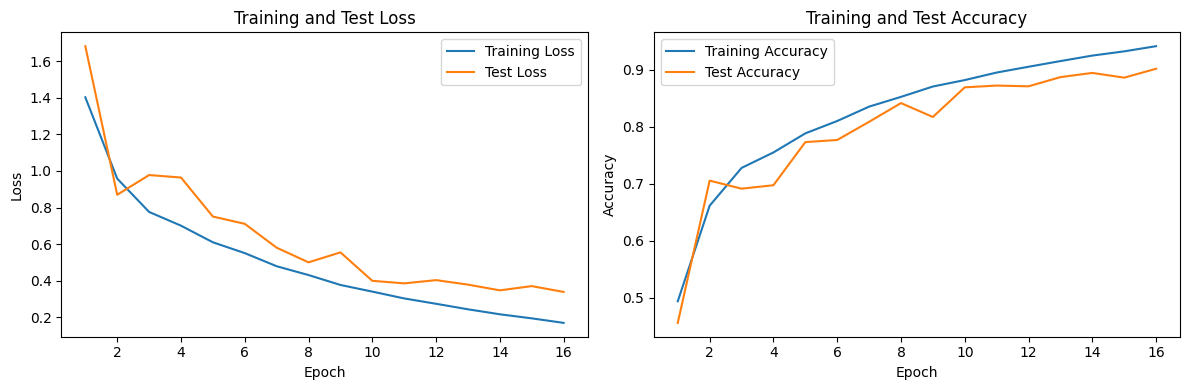

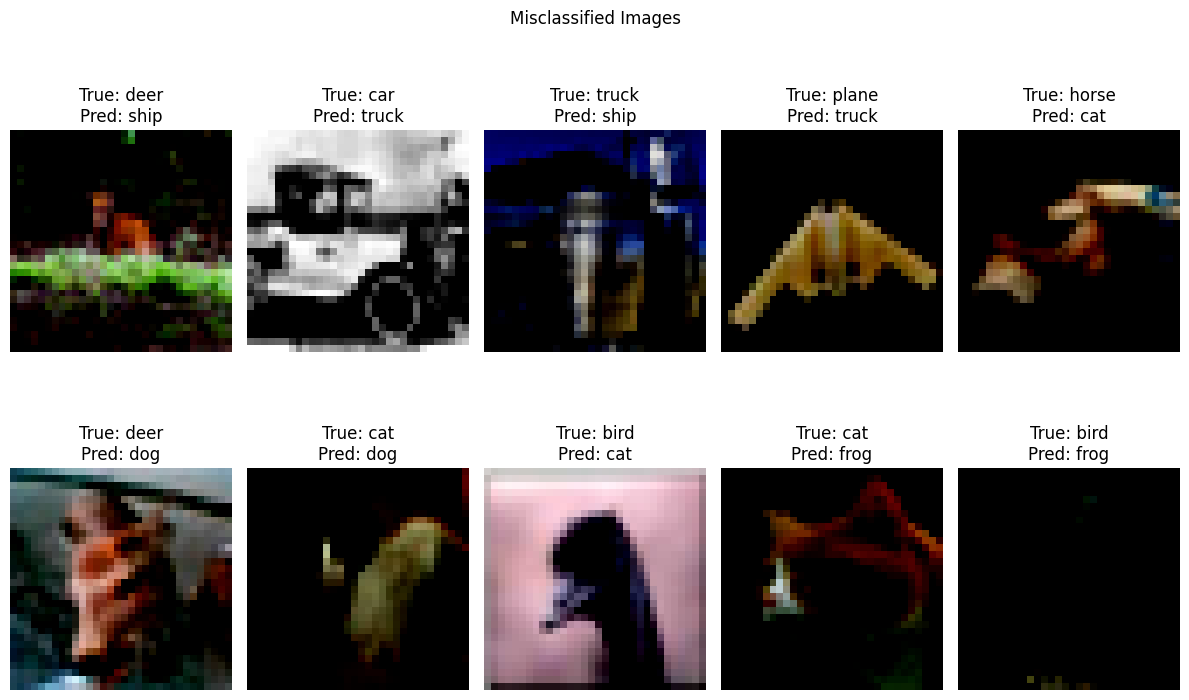

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.datasets as datasets
from torchvision.transforms import functional as F

from model import ResNet
from utils import train, test, get_max_test_accuracy, plot_loss_accuracy, show_misclassified_images
from torch_lr_finder import LRFinder
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 24
batch_size = 512
target_accuracy = 0.9  # 90% target accuracy

# CIFAR-10 dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomly crop the image with padding of 4 pixels
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define Cutout transform
class Cutout:
    def __init__(self, length):
        self.length = length

    def __call__(self, image):
        width, height = image.size
        image = np.array(image)

        if len(image.shape) == 2:
            # Grayscale image, convert to RGB
            image = np.stack([image] * 3, axis=2)

        x = np.random.randint(0, width - self.length)
        y = np.random.randint(0, height - self.length)

        image[y:y + self.length, x:x + self.length, :] = 0

        return Image.fromarray(image)


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Apply Cutout transform to each image in the dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True,
                                 transform=transforms.Compose([
                                     Cutout(8),
                                     transform_train
                                 ]))

test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

class_labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create ResNet model instance
model = ResNet().to(device)

# LR Finder
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, weight_decay=5e-4)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=100, step_mode="exp")

# Get LR Range
lr_finder.plot()  # Plot the loss versus learning rate
lr_finder.reset()  # Reset the model and optimizer to their initial state

min_lr = lr_finder.history["lr"][np.argmin(lr_finder.history["loss"])]
max_lr = lr_finder.history["lr"][np.argmax(lr_finder.history["loss"])]

print(f"Min LR: {min_lr:.6f}, Max LR: {max_lr:.6f}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=num_epochs, steps_per_epoch=len(train_loader))

# Training loop
train_losses = []
train_acc = []
test_losses = []
test_acc = []
class_acc = []
max_test_accuracy = 0.0
best_epoch = 0

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion, scheduler)
    test_loss, test_accuracy, class_correct, class_total = test(model, device, test_loader, criterion)
    class_accuracy = [class_correct[i] / class_total[i] for i in range(10)]

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    test_losses.append(test_loss)
    test_acc.append(test_accuracy)
    class_acc.append(class_accuracy)

    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"LR: {scheduler.get_last_lr()}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Acc: {train_accuracy:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Test Acc: {test_accuracy:.4f}")

    # Check if current test accuracy is the maximum so far
    if test_accuracy > max_test_accuracy:
        max_test_accuracy = test_accuracy
        best_epoch = epoch + 1

    # Check if target accuracy is reached
    if test_accuracy >= target_accuracy:
        print('Target accuracy of {}% reached at epoch {}'.format(target_accuracy, epoch + 1))
        break

# Print maximum test accuracy and its corresponding epoch
max_test_acc, max_epoch = get_max_test_accuracy(test_acc)
print(f"Maximum Test Accuracy: {max_test_acc:.4f} at Epoch: {max_epoch + 1}")

# Plot loss and accuracy curves
plot_loss_accuracy(train_losses, train_acc, test_losses, test_acc)

# Show misclassified images
show_misclassified_images(device, model, test_loader, class_labels, num_samples=10)
